In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt


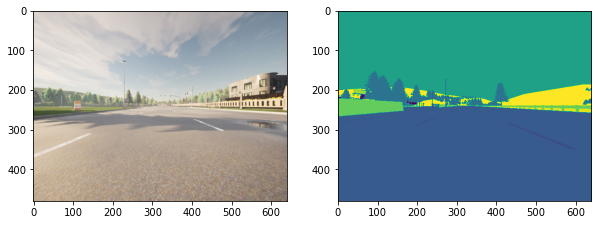

In [10]:
# Handle the data
imageMask_path = "./datasets/W3_Files/data/CameraMask/"
imageRGB_path = "./datasets/W3_Files/data/CameraRGB/"

origImages = os.listdir(imageRGB_path)
image_list = [imageRGB_path + i for i in origImages]
mask_list = [imageMask_path + i for i in origImages]

N = 10

rgb = imageio.v2.imread(image_list[N])
mask = imageio.v2.imread(mask_list[N])

fig = plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.subplot(1,2,2)
plt.imshow(mask[:, :, 0])
plt.show()

# Making the image datasets
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle = False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle = False)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [11]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [12]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = 3, kernel_initializer = "he_normal", padding = "same", activation = "relu")(inputs)
    conv = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = 3, kernel_initializer = "he_normal", padding = "same", activation = "relu")(conv)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(rate = dropout_prob)(conv)
         
    if max_pooling:
        next_layer = tf.keras.layers.MaxPool2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection
    
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = tf.keras.layers.Conv2DTranspose(filters = n_filters, kernel_size = (3,3), strides = (2,2), padding = "same")(expansive_input) 
    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)
    conv = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = 3, kernel_initializer = "he_normal", padding = "same", activation = "relu")(merge)
    conv = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = 3, kernel_initializer = "he_normal", padding = "same", activation = "relu")(conv)
    
    return conv


In [13]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = tf.keras.layers.Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters * 1)
    ### END CODE HERE

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = tf.keras.layers.Conv2D(n_classes, 1, padding="same")(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [22]:
def displayResult(displayList):
    """
    Displays the results in subplots
    """
    len___ = len(displayList)
    plt.figure(figsize=(15,12))
    title = ["Input image", "True mask", "Predicted results"]

    for i in range(len(displayList)):
        plt.subplot(1,len___, i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(displayList[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


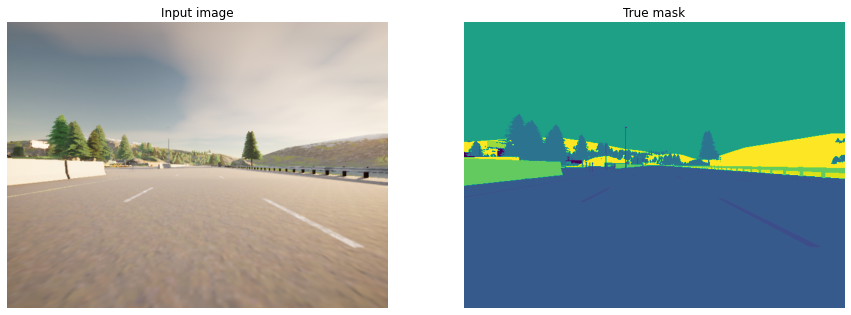

In [23]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
displayResult([sample_image, sample_mask])

(96, 128, 1)


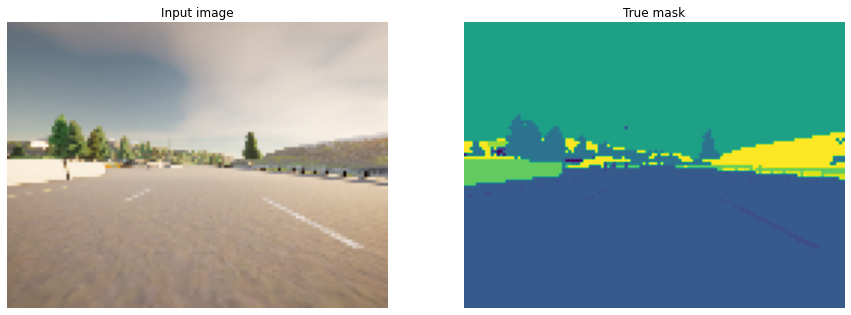

In [25]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
displayResult([sample_image, sample_mask])

In [27]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5
34/34 [==============================] - 108s 3s/step - loss: 1.8390 - accuracy: 0.4391
Epoch 2/5
34/34 [==============================] - 108s 3s/step - loss: 0.9721 - accuracy: 0.7400
Epoch 3/5
34/34 [==============================] - 101s 3s/step - loss: 0.6347 - accuracy: 0.8233
Epoch 4/5
34/34 [==============================] - 94s 3s/step - loss: 0.5102 - accuracy: 0.8530
Epoch 5/5
34/34 [==============================] - 94s 3s/step - loss: 0.4317 - accuracy: 0.8757


1/1 [==============================] - 1s 618ms/step


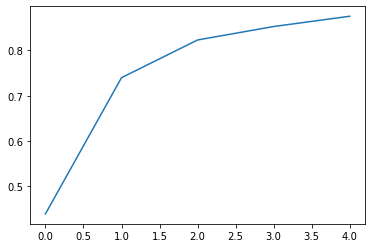

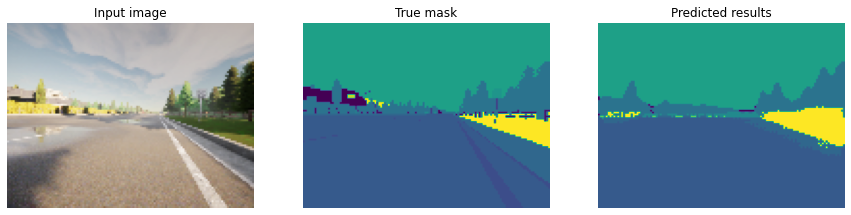

1/1 [==============================] - 1s 733ms/step


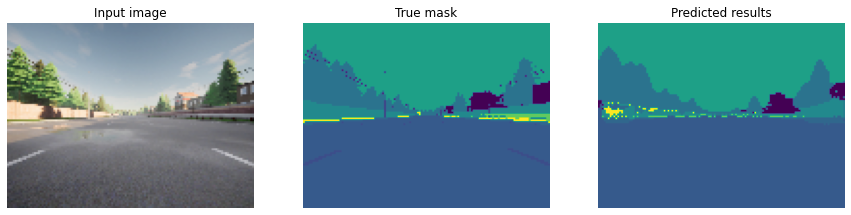

1/1 [==============================] - 1s 772ms/step


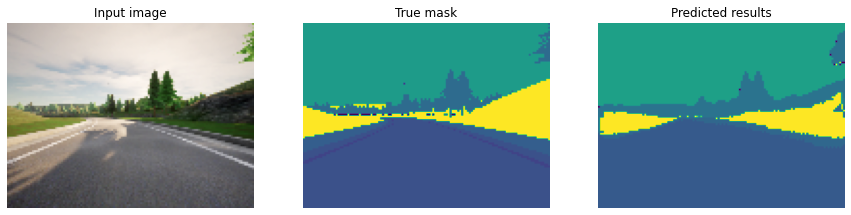

1/1 [==============================] - 1s 599ms/step


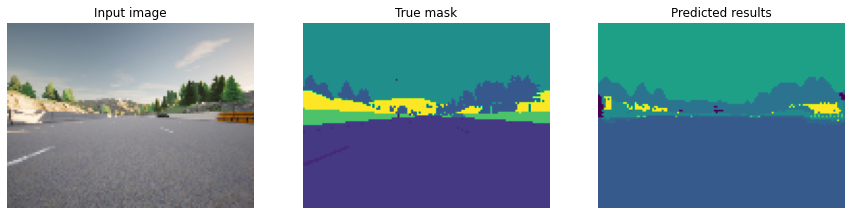

1/1 [==============================] - 1s 756ms/step


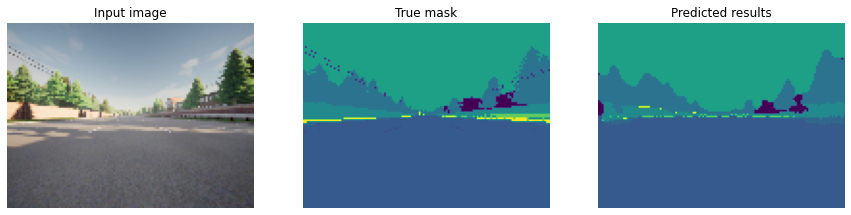

1/1 [==============================] - 1s 637ms/step


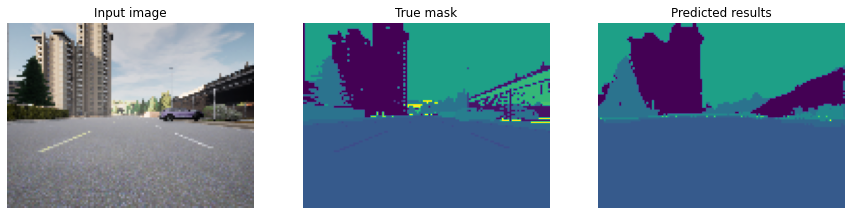

In [30]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image)
        displayResult([image[0], mask[0], create_mask(pred_mask)])

        
plt.plot(model_history.history["accuracy"])

show_predictions(train_dataset, 6)